In [1]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler, LabelEncoder
import numpy as np
from sklearn.pipeline import Pipeline

In [2]:
training_file = "wildfires_training.csv"
test_file = "wildfires_test.csv"

df = pd.read_csv("wildfires_training.csv")
df_test = pd.read_csv("wildfires_test.csv")

dependent_variable = "fire"
independent_variables = [col for col in df.columns if col != dependent_variable]

In [3]:
# Training predictors and response variables
X_training = df[independent_variables]
y_training = df[dependent_variable]
y_training = LabelEncoder().fit_transform(y_training)

In [4]:
X_test = df_test[independent_variables]
y_test = df_test[dependent_variable]
y_test = LabelEncoder().fit_transform(y_test)

In [5]:
max_depth = np.arange(2, 20, 2)
criteria = ["gini", "entropy", "log_loss"]

In [6]:
training_test_comparison = {}

for criterion in criteria:
    models_info = []
    for n in max_depth:
        rf_pipe = Pipeline(
            [
                ("scaler", StandardScaler()),
                (
                    "rf",
                    RandomForestClassifier(
                        random_state=42,
                        criterion=criterion,
                        max_depth=n,
                        n_estimators=30,
                        oob_score=True,
                        max_features="log2",
                    ),
                ),
            ]
        )
        rf_pipe.fit(X_training, y_training)

        # predictions
        y_pred_train = rf_pipe.predict(X_training)
        y_pred_test = rf_pipe.predict(X_test)

        # accuracies
        accuracy_train = metrics.accuracy_score(y_training, y_pred_train)
        accuracy_test = metrics.accuracy_score(y_test, y_pred_test)

        # probability outputs
        y_probs = rf_pipe.predict_proba(X_test)[:, 1]

        models_info.append(
            {
                "criterion": criterion,
                "max_depth": n,
                "train_accuracy": accuracy_train,
                "test_accuracy": accuracy_test,
                "pipeline": rf_pipe,
                "predictions": y_pred_test,
                "oob_score": rf_pipe.named_steps["rf"].oob_score_,
            }
        )

    training_test_comparison[criterion] = models_info

In [7]:
best_model = {}
for criterion in criteria:
    best_model[criterion] = max(
        training_test_comparison[criterion], key=lambda x: x["test_accuracy"]
    )

In [8]:
for criterion, model in best_model.items():
    print(f"Best {criterion} index model:")
    print(f"  Max Depth = {model['max_depth']}")
    print(f"  Training Accuracy = {model['train_accuracy']:.4f}")
    print(f"  Test Accuracy = {model['test_accuracy']:.4f}")
    print(f"  OOB score = {model['oob_score']:.4f}\n")

Best gini index model:
  Max Depth = 4
  Training Accuracy = 0.9805
  Test Accuracy = 0.8400
  OOB score = 0.9026

Best entropy index model:
  Max Depth = 10
  Training Accuracy = 1.0000
  Test Accuracy = 0.9000
  OOB score = 0.8896

Best log_loss index model:
  Max Depth = 10
  Training Accuracy = 1.0000
  Test Accuracy = 0.9000
  OOB score = 0.8896



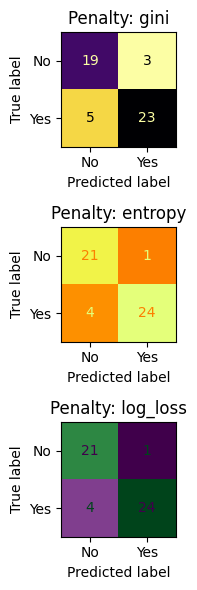

In [9]:
from matplotlib import pyplot as plt
from matplotlib.pyplot import colormaps
import random
from sklearn.metrics import ConfusionMatrixDisplay

fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(6, 6))
ax = ax.flatten()

for i, (penalty, model_info) in enumerate(best_model.items()):
    y_pred = model_info["predictions"]

    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No", "Yes"])
    disp.plot(cmap=random.choice(list(colormaps)), ax=ax[i], colorbar=False)
    disp.ax_.set_title(f"Penalty: {penalty}")

plt.tight_layout()
plt.show()

### Training and Test Set Accuracy

In [10]:
gini = training_test_comparison["gini"]
entropy = training_test_comparison["entropy"]
log_loss = training_test_comparison["log_loss"]

In [11]:
accuracy_training_gini = [el["train_accuracy"] for el in gini]
accuracy_test_gini = [el["test_accuracy"] for el in gini]

In [12]:
accuracy_training_entropy = [el["train_accuracy"] for el in entropy]
accuracy_test_entropy = [el["test_accuracy"] for el in entropy]

In [13]:
accuracy_training_log = [el["train_accuracy"] for el in log_loss]
accuracy_test_log = [el["test_accuracy"] for el in log_loss]

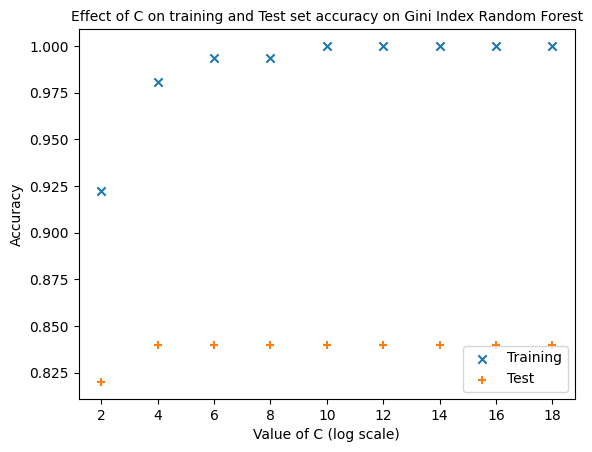

In [14]:
plt.scatter(max_depth, accuracy_training_gini, marker="x")
plt.scatter(max_depth, accuracy_test_gini, marker="+")
plt.xlabel("Value of C (log scale)")
plt.ylabel("Accuracy")
plt.legend(["Training", "Test"], loc=4)
plt.title(
    "Effect of C on training and Test set accuracy on Gini Index Random Forest",
    fontsize=10,
)
plt.show()

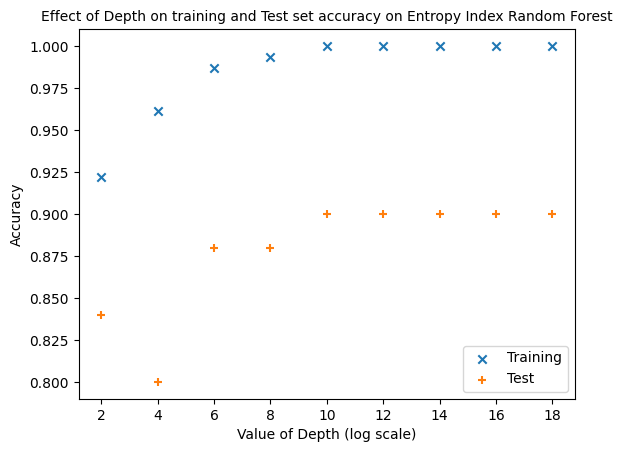

In [15]:
plt.scatter(max_depth, accuracy_training_entropy, marker="x")
plt.scatter(max_depth, accuracy_test_entropy, marker="+")
plt.xlabel("Value of Depth (log scale)")
plt.ylabel("Accuracy")
plt.legend(["Training", "Test"], loc=4)
plt.title(
    "Effect of Depth on training and Test set accuracy on Entropy Index Random Forest",
    fontsize=10,
)
plt.show()

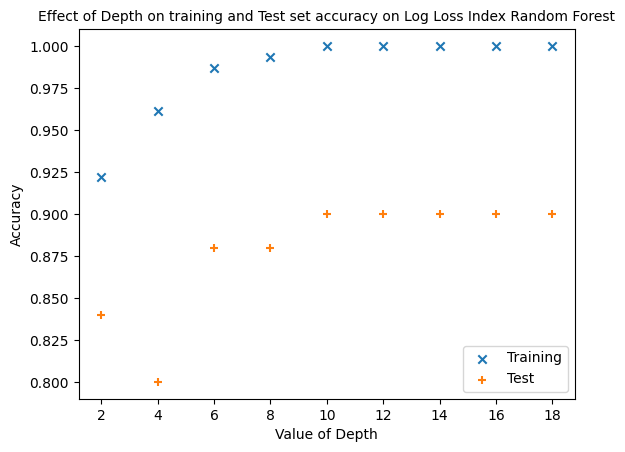

In [16]:
plt.scatter(max_depth, accuracy_training_log, marker="x")
plt.scatter(max_depth, accuracy_test_log, marker="+")
plt.xlabel("Value of Depth")
plt.ylabel("Accuracy")
plt.legend(["Training", "Test"], loc=4)
plt.title(
    "Effect of Depth on training and Test set accuracy on Log Loss Index Random Forest",
    fontsize=10,
)
plt.show()

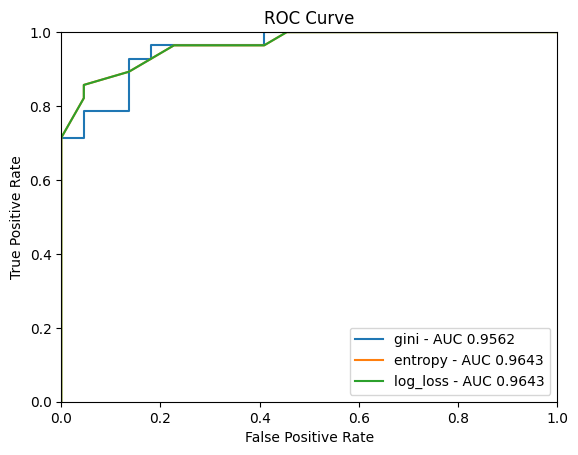

In [17]:
from sklearn.metrics import roc_curve, auc

for i, pen in enumerate(criteria):
    best_model = max(training_test_comparison[pen], key=lambda x: x["test_accuracy"])
    y_probs = best_model["pipeline"].predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_probs)
    plt.plot(fpr, tpr, label=f"{pen} - AUC {auc(fpr, tpr):.4f}")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend(loc="lower right")
    plt.title("ROC Curve")

In [18]:
from sklearn.metrics import classification_report

for i, pen in enumerate(criteria):
    best_model = max(training_test_comparison[pen], key=lambda x: x["test_accuracy"])
    title = f"\n\t\t\t{pen.upper()} Index Random Forest"
    print(f"{title}\n{classification_report(y_test, best_model['predictions'])}\n")


			GINI Index Random Forest
              precision    recall  f1-score   support

           0       0.79      0.86      0.83        22
           1       0.88      0.82      0.85        28

    accuracy                           0.84        50
   macro avg       0.84      0.84      0.84        50
weighted avg       0.84      0.84      0.84        50



			ENTROPY Index Random Forest
              precision    recall  f1-score   support

           0       0.84      0.95      0.89        22
           1       0.96      0.86      0.91        28

    accuracy                           0.90        50
   macro avg       0.90      0.91      0.90        50
weighted avg       0.91      0.90      0.90        50



			LOG_LOSS Index Random Forest
              precision    recall  f1-score   support

           0       0.84      0.95      0.89        22
           1       0.96      0.86      0.91        28

    accuracy                           0.90        50
   macro avg       0.90      0.9

In [19]:
### Training / Test Scores Vs OOB Scores

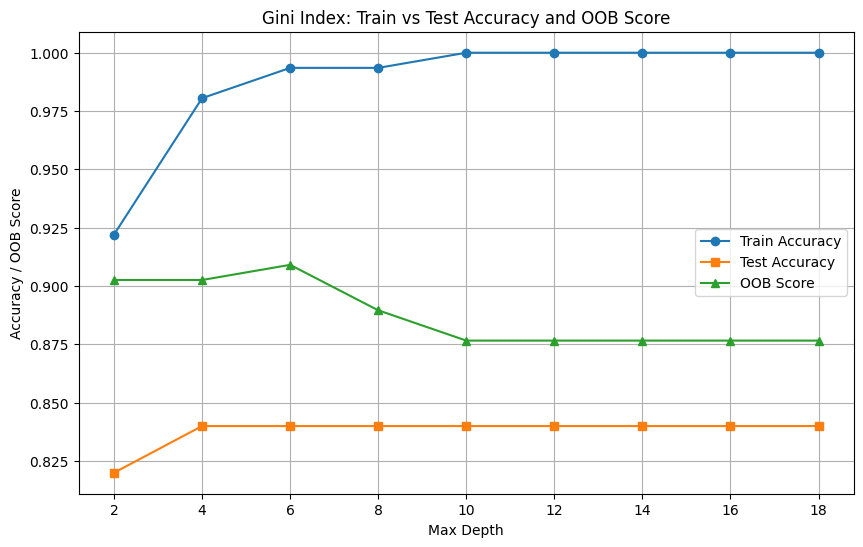

In [20]:
plt.figure(figsize=(10, 6))
oob_score = [el["oob_score"] for el in gini]
plt.plot(max_depth, accuracy_training_gini, label="Train Accuracy", marker="o")
plt.plot(max_depth, accuracy_test_gini, label="Test Accuracy", marker="s")
plt.plot(max_depth, oob_score, label="OOB Score", marker="^")
plt.xlabel("Max Depth")
plt.ylabel("Accuracy / OOB Score")
plt.title("Gini Index: Train vs Test Accuracy and OOB Score")
plt.legend()
plt.grid(True)
plt.show()

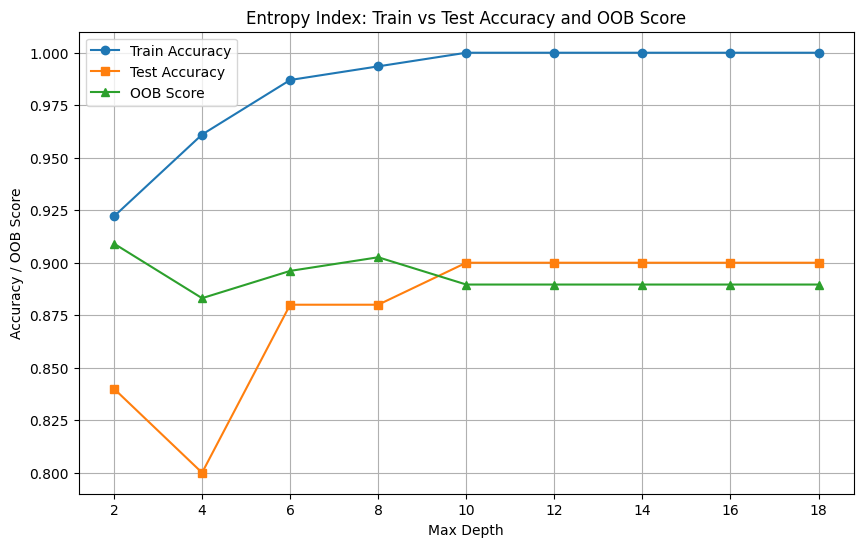

In [21]:
plt.figure(figsize=(10, 6))
oob_score = [el["oob_score"] for el in entropy]
plt.plot(max_depth, accuracy_training_entropy, label="Train Accuracy", marker="o")
plt.plot(max_depth, accuracy_test_entropy, label="Test Accuracy", marker="s")
plt.plot(max_depth, oob_score, label="OOB Score", marker="^")
plt.xlabel("Max Depth")
plt.ylabel("Accuracy / OOB Score")
plt.title("Entropy Index: Train vs Test Accuracy and OOB Score")
plt.legend()
plt.grid(True)
plt.show()

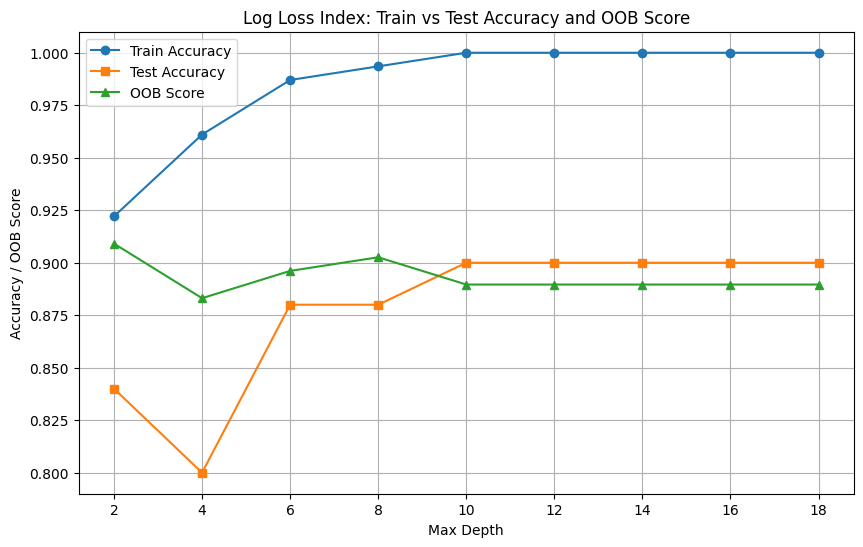

In [22]:
plt.figure(figsize=(10, 6))
oob_score = [el["oob_score"] for el in log_loss]
plt.plot(max_depth, accuracy_training_log, label="Train Accuracy", marker="o")
plt.plot(max_depth, accuracy_test_log, label="Test Accuracy", marker="s")
plt.plot(max_depth, oob_score, label="OOB Score", marker="^")
plt.xlabel("Max Depth")
plt.ylabel("Accuracy / OOB Score")
plt.title("Log Loss Index: Train vs Test Accuracy and OOB Score")
plt.legend()
plt.grid(True)
plt.show()

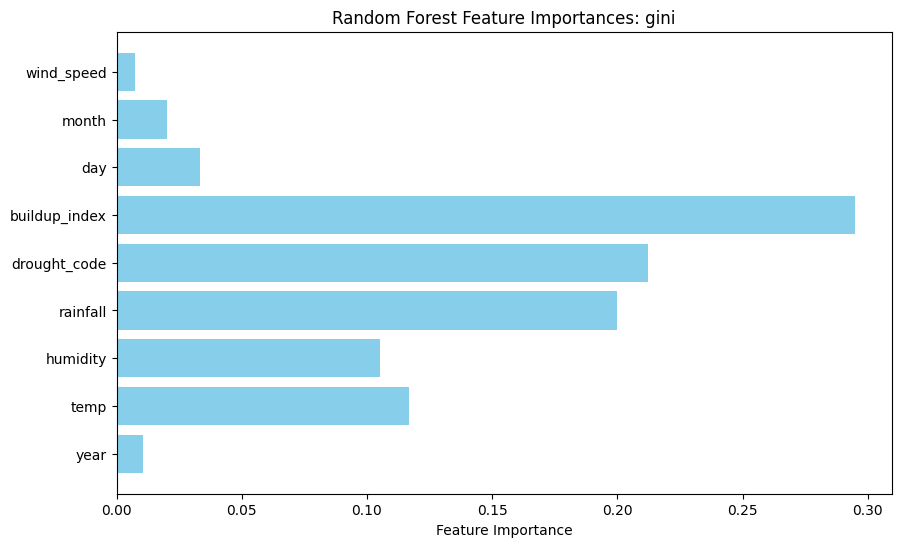

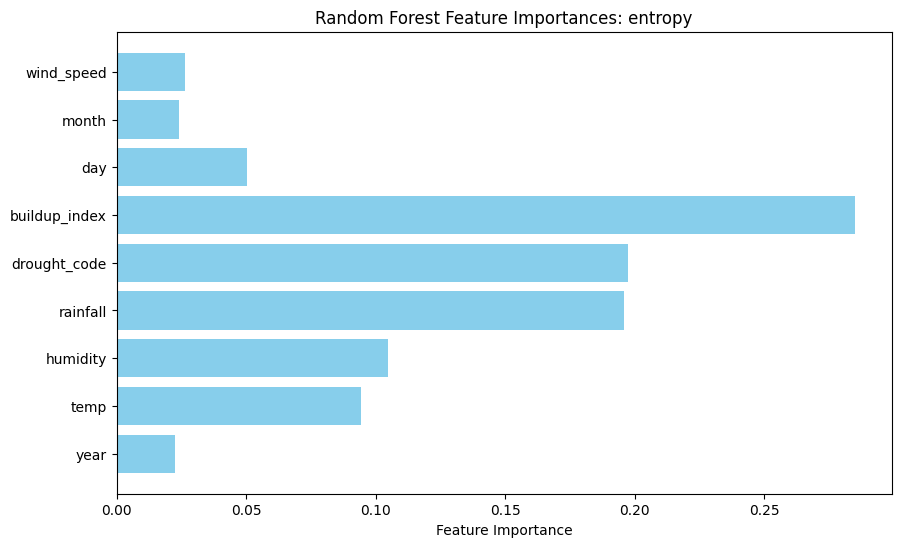

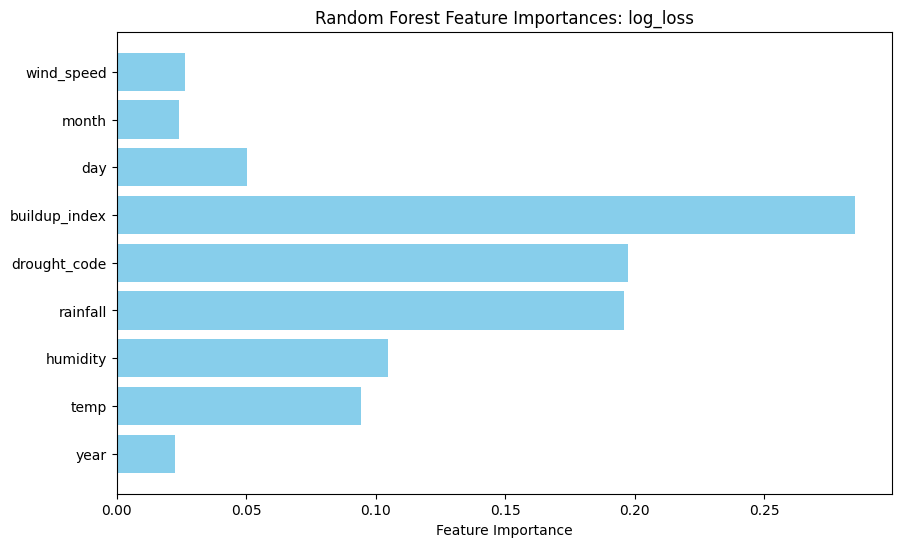

In [39]:
for i, pen in enumerate(criteria):
    plt.figure(figsize=(10, 6))
    best_model = max(training_test_comparison[pen], key=lambda x: x["test_accuracy"])
    rf = best_model["pipeline"].named_steps["rf"]
    feature_importance = rf.feature_importances_
    feature_names = X_training.columns

    plt.barh(feature_names, feature_importance, color="skyblue")
    plt.xlabel("Feature Importance")
    plt.title(f"Random Forest Feature Importances: {pen}")
    plt.show()